<a href="https://colab.research.google.com/github/AgaMiko/pixel_character_generator/blob/master/notebooks/5_DC_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder - Pixel character generation
Author: Agnieszka Mikołajczyk https://github.com/AgaMiko

- Mean square error loss
- Convolutional encoder and decoder
- Embedding size (encoder output -> decoder input) equal to 40

Link to colab: https://colab.research.google.com/drive/1B-8dbixg1AVVnYuBFPzqlh_IShPX2vGX?usp=sharing
Link to github: https://github.com/AgaMiko/100-days-of-code

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

In [0]:
!pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
# Set random seed for reproducibility
manualSeed = '123'
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [6]:
from google.colab import files
uploaded = files.upload()
!unzip -q data.zip #uzipping dataset

Saving data.zip to data.zip


In [0]:
dataroot = "."

workers = 2 # Number of workers for dataloader
batch_size = 100 
image_size = 64

channels = 3

latent_size = 40
condition_size = 10
feature_map_size = 64
num_epochs = 5000

beta1 = 0.5
ngpu = 1

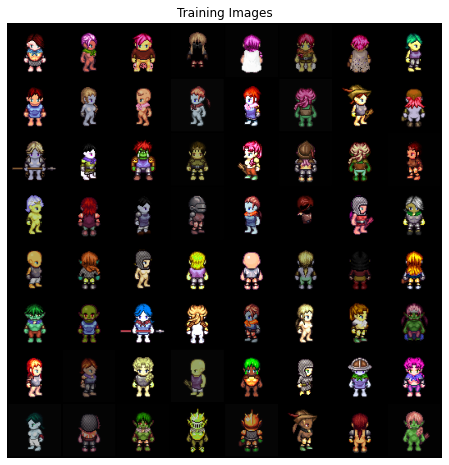

In [8]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot+'/data',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
 
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_map_size * 8, feature_map_size, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(feature_map_size,latent_size),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main(input)
        x = x.view(x.size(0),-1)
        x = self.fc_class(x)
        return x


In [0]:

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu


        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, embedding):
      embedding = embedding.view(embedding.size(0),embedding.size(1),1,1)
      reconstructed_output = self.main(embedding)
      return reconstructed_output

In [108]:
class Autoencoder(nn.Module):
  def __init__(self, ngpu):
    super(Autoencoder,self).__init__()

    self.encoder = Encoder(ngpu).to(device)
    self.decoder = Decoder(ngpu).to(device)

  def forward(self, input, mode = 'train'):
    if mode == 'train':
      x = self.encoder(input)
      return self.decoder(x)

    if mode == 'generate':
      return self.decoder(input)

autoencoder = Autoencoder(ngpu)

print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.2, inplace=False)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Dropout(p=0.2, inplace=False)
      (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.2)
      (13): Conv2d(512, 64, kernel_size=(4, 4), stride=(

In [0]:
# Training Loop

# Initialize BCELoss function
criterion = nn.MSELoss()

eps = 1e-10
lr=1e-4
optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
iters = 0
losses=[]
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        
        autoencoder.zero_grad()
        image = data[0].to(device)
        b_size = image.size(0)
        
        reconstructed_image = autoencoder(image).view(-1)

        err = criterion(reconstructed_image.view(image.size())+eps, image)
        err.backward()
        
        optimizer.step()
       
        # Output training stats
        if i % 50 == 0:
            print('[{0}/{1}][{2}/{3}] \t Loss: {4}'.format(epoch, num_epochs, i, len(dataloader), err.item()))

        # Save Losses for plotting later
        losses.append(err.item())

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = autoencoder(fixed_noise,data[1].long().to(device)).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    lr *= 0.995
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=(beta1, 0.999))


No handles with labels found to put in legend.


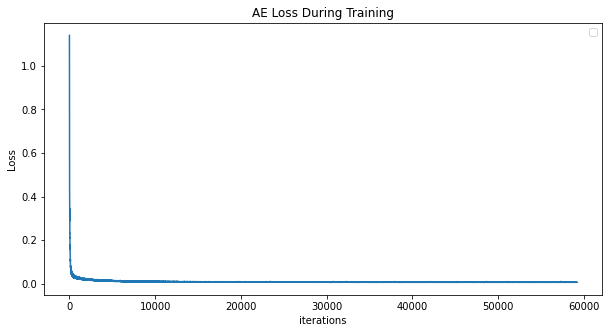

In [110]:
plt.figure(figsize=(10,5))
plt.title("AE Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

RuntimeError: ignored

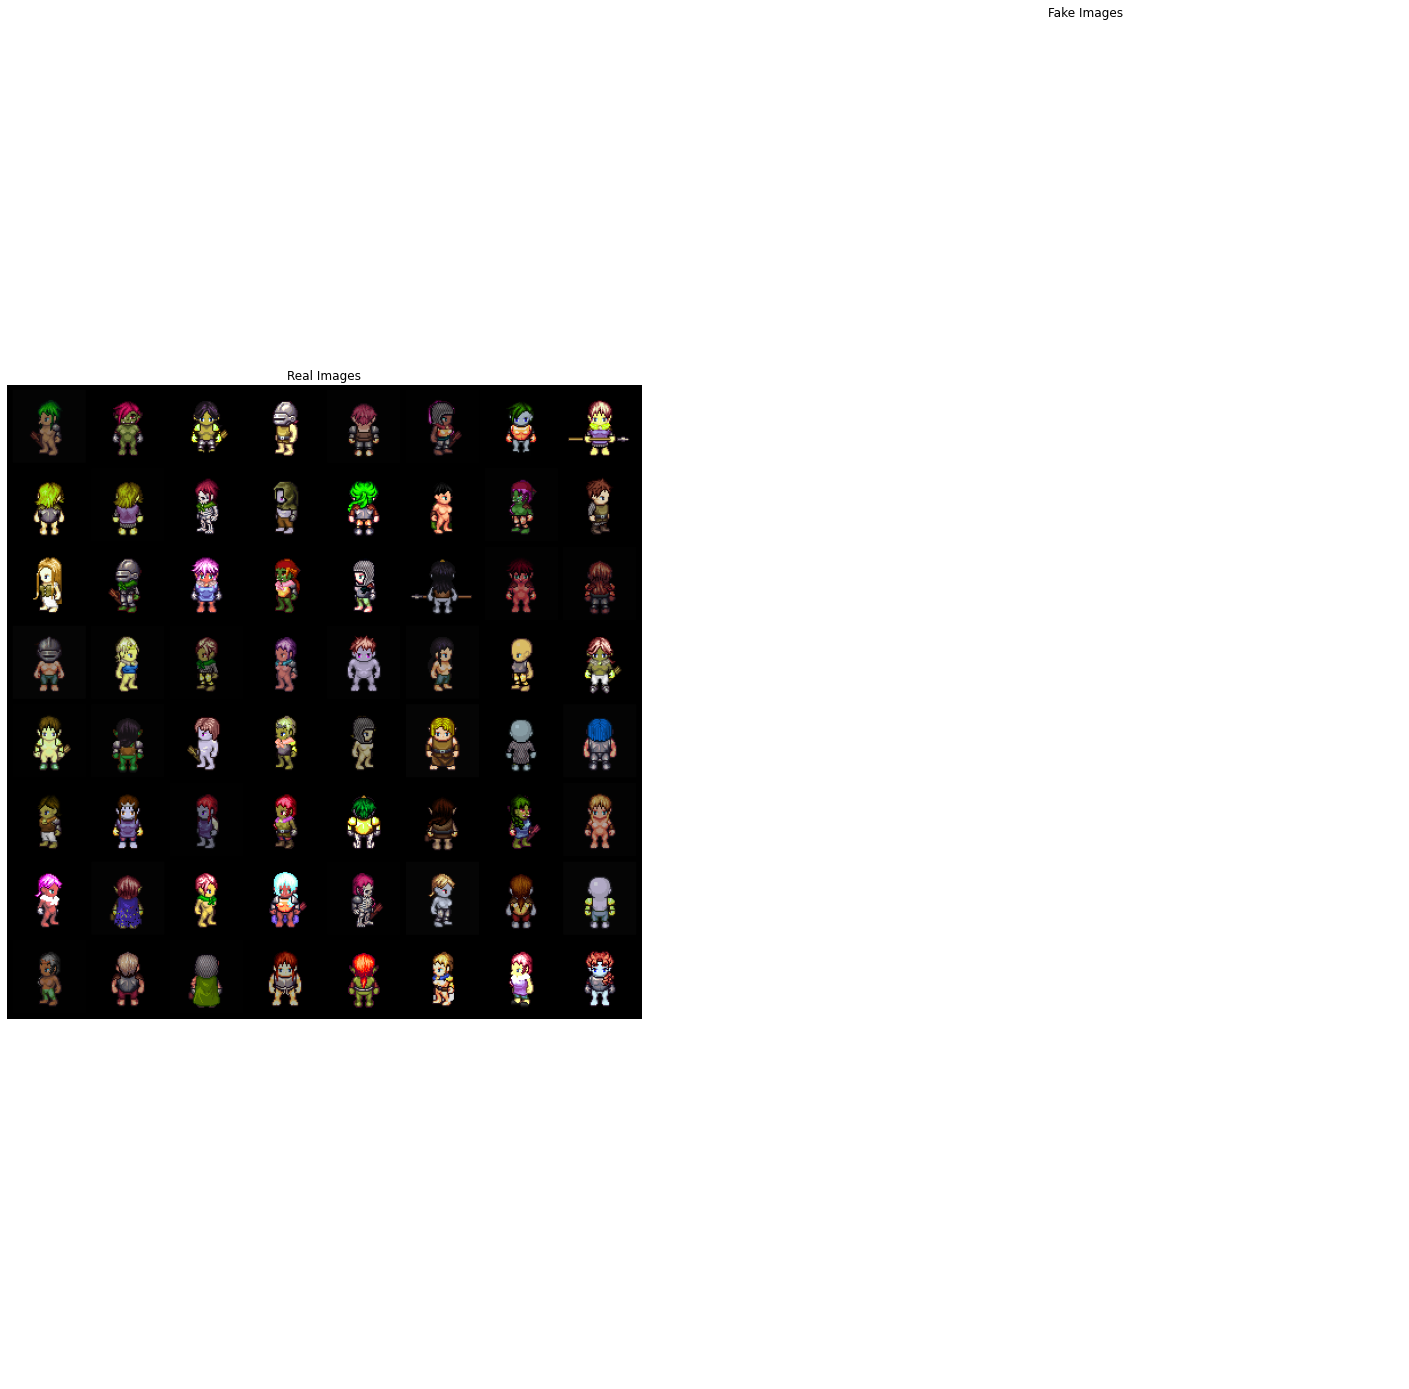

In [91]:


# Plot the fake images from the last epoch
fake = autoencoder(real_batch[0].to(device))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

torch.Size([100, 3, 64, 64])


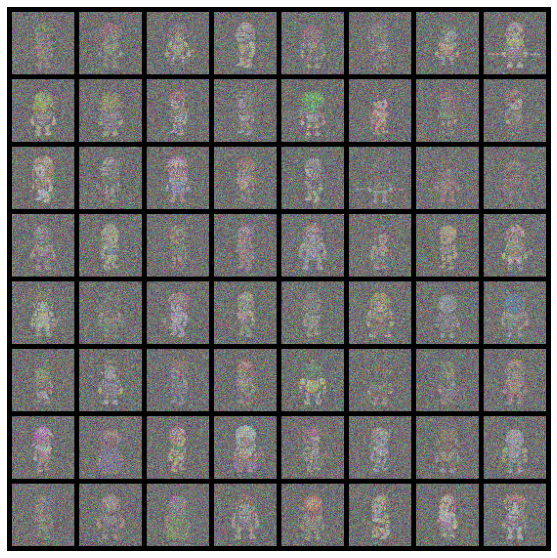

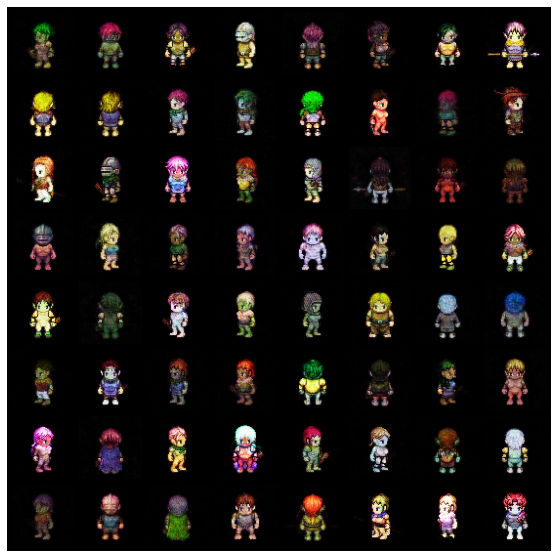

In [135]:
fake=[]
batch=4
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

with torch.no_grad():
  for k in range(1):
    fixed_noise = torch.randn(100, 3,64, 64, device=device)
    plt.figure(figsize=(10,10))
    #print(fixed_noise.size())
    print(real_batch[0].size())
    real_noised = real_batch[0].to(device)+fixed_noise*0.9
    plt.axis("off")
    plt.title("Real Images + Noise")
    plt.imshow(np.transpose(vutils.make_grid(real_noised.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    fake = autoencoder(real_noised.to(device))
    #print(fake.size())
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Reconstructed Images")
    plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
      